In [51]:
import os, sys

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rc('mathtext', fontset="cm")
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from utils.utils import Create_Similarity_Model

sns.set_style('whitegrid')
sns.set_context("talk")

## Now we will create our model

In [52]:
n_nonsimilar = 1
n_similar = 1

### We will look for similarity in the last n_similar parameters of the inputs.

## Load the MVP data for high enough Re

In [56]:
df_full=pd.ExcelFile("../../Data/Boundary Layer Data/BL_Data_Final_Vallikivi_etal_2015.xlsx")
df_NSTAP = pd.read_excel(df_full, 'NSTAP_data')
df_Pitot = pd.read_excel(df_full, 'Pitot_Data')

dfs = []
Re_tau = []
Y_ = []
U_ = []
possible_re_tau = [2621.5, 4634.5, 8261.3, 14717.0, 25062.0, 40053.0, 72526.0]
dic_x = {}
dic_y = {}

for i in range(2, len(possible_re_tau)):
    possible_y = df_NSTAP.iloc[2:, 4*i].values
    possible_u = df_NSTAP.iloc[2:, 4*i + 1].values
    for j in range(len(possible_y)):
        if possible_y[j] > 0.1 * possible_re_tau[i]:
            Y_.append(possible_y[j])
            U_.append(possible_u[j])
            Re_tau.append(possible_re_tau[i])

c = list(zip(Y_, Re_tau, U_))
random.shuffle(c)
Y_, Re_tau, U_ = zip(*c)

Y_ = np.log(Y_)
Re_tau = np.log(Re_tau)

dic_x['y+'] = Y_
dic_x['re_tau'] = Re_tau
dic_y['u+'] = np.array(U_)

nonsimilar_keys = ['y+']

xtrain = pd.DataFrame.from_dict(dic_x).values
ytrain = pd.DataFrame.from_dict(dic_y).values
print(len(Y_))

115


In [48]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
n_fits = 20                       # Number of model fits we will try to perform
n_epochs_initial = 100           # Number of epochs we will train inside the loop
n_epochs_final = 10000            # Number of epochs we will train after convergence is established
successfull_tries = 0
models = []

# model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
# model.compile(loss = loss, optimizer = optimizer)
# model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 2)

while successfull_tries < n_fits:
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    if current_loss < 200:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        models.append(model)
        print("Iteration " + str(successfull_tries) + ": current loss = " + str(good_loss))
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

Iteration 1: current loss = 0.30136147141456604
Iteration 2: current loss = 0.2550099790096283
Iteration 3: current loss = 1.2798120975494385
Iteration 4: current loss = 0.28460532426834106
Iteration 5: current loss = 0.37391340732574463
Iteration 6: current loss = 0.7914445996284485
Iteration 7: current loss = 1.1221446990966797
Iteration 8: current loss = 0.5819627046585083
Iteration 9: current loss = 0.2608073055744171
Iteration 10: current loss = 0.6803327202796936
Iteration 11: current loss = 0.8754799365997314
Iteration 12: current loss = 0.24366667866706848
Iteration 13: current loss = 0.4063086211681366
Iteration 14: current loss = 0.26447156071662903
Iteration 15: current loss = 0.5811169147491455
Iteration 16: current loss = 0.6646056771278381
Iteration 17: current loss = 1.5206624269485474
Iteration 18: current loss = 0.2863571047782898
Iteration 19: current loss = 0.34856247901916504
Iteration 20: current loss = 3.5710654258728027


In [49]:
# best_model.fit(xtrain, ytrain, epochs = 10000, verbose = 0)
best_model.evaluate(xtrain, ytrain, verbose = 0)

0.24366667866706848

In [50]:
for i in range(n_nonsimilar):
    similarity_exponents = best_model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
    print('Exponents multiplicating inside the function for ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = best_model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function: ' + str(multiplication_exponents))

Exponents multiplicating inside the function for y+: [-0.22105123]
Exponents multiplicating outside the function: [0.01472559]


In [17]:
scaling_factor_y = 1.009
scaling_factor_u = 0.075

y__ = []
u__ = []
Re_tau = possible_re_tau
Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

for i in range(len(dfs)):
    yplus = dfs[i]['y+']
    uplus = dfs[i]['U+']
    y__.append(yplus / (Re_tau[i] ** scaling_factor_y))
    u__.append(uplus / (Re_tau[i] ** scaling_factor_u))

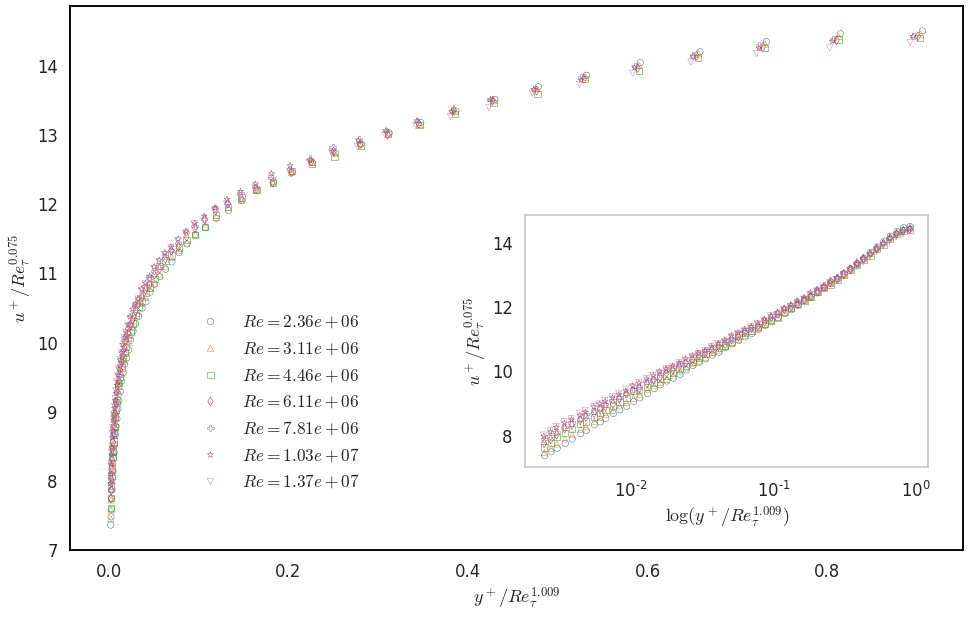

In [19]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(dfs)):
    ax1.scatter(y__[i][:-1] , u__[i][:-1] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re= $'+r'${:.2e}$'.format(Re[i]))
    j+=1

j=0
for i in range(len(dfs)):
    ax2.scatter(y__[i][:-1] , u__[i][:-1] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Mck, Re= '+'{:.2e}'.format(Re[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+/Re_\tau^{1.009}$")
ax1.set_ylabel(r'$u^+/Re_\tau^{0.075}$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+/Re_\tau^{1.009})$")
ax2.set_ylabel(r'$u^+/Re_\tau^{0.075}$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('BarenNet exponents for MVP.pdf', format='pdf', dpi=1200)
plt.show()